In [1]:
from __future__ import print_function
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
%matplotlib inline
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def load_data(path):
    return pd.read_csv(path)

In [3]:
path = "/home/anhduc/Documents/data/ToyotaCorolla.csv"

In [4]:
toyota = load_data(path)

In [5]:
toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
Price        1436 non-null int64
Age          1436 non-null int64
KM           1436 non-null int64
FuelType     1436 non-null object
HP           1436 non-null int64
MetColor     1436 non-null int64
Automatic    1436 non-null int64
CC           1436 non-null int64
Doors        1436 non-null int64
Weight       1436 non-null int64
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


In [6]:
# 10 điểm dữ liệu đầu tiên
toyota.head(10)

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170
5,12950,32,61000,Diesel,90,0,0,2000,3,1170
6,16900,27,94612,Diesel,90,1,0,2000,3,1245
7,18600,30,75889,Diesel,90,1,0,2000,3,1245
8,21500,27,19700,Petrol,192,0,0,1800,3,1185
9,12950,23,71138,Diesel,69,0,0,1900,3,1105


# Linear Regression

In [7]:
# Parameters 
learning_rate = 0.001
batch_sizes = 200
n_epochs = 1000

In [8]:
encoder = LabelBinarizer()
toyota['FuelType'] = encoder.fit_transform(toyota['FuelType'])

In [9]:
scaler = StandardScaler()
toyota_features = toyota.drop('Price', axis=1)

In [10]:
x_data = scaler.fit_transform(toyota_features)
y_data = np.array(toyota['Price'])
y_data = y_data.reshape(y_data.shape[0], 1)

/home/anhduc/environments/my_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/anhduc/environments/my_env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [12]:
n_dim = x_train.shape[1]
X = tf.placeholder(tf.float32, [None, n_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [13]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"

logdir = "{}/run-{}/".format(root_logdir, now)

In [14]:
with tf.name_scope("name_loss"):
    w = tf.Variable(tf.ones([n_dim, 1]))
    b = tf.Variable(0.0, tf.float32)
    Y_pred = tf.add(tf.matmul(X, w), b)
    loss = tf.reduce_mean(tf.square(Y_pred-Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
loss_summary = tf.summary.scalar('LOSS', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [15]:

loss_history = {}
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        sess.run(optimizer, feed_dict={X: x_train, Y: y_train})
        test_loss = sess.run(loss, feed_dict={X: x_test, Y: y_test})

        loss_history[epoch] = test_loss
        if (epoch%50==0):
            print('Epoch: {0}, test_loss: {1}'.format(epoch, test_loss))
            # summary_str = sess.run(loss_summary, feed_dict={X: x_train, Y: y_train})
            # file_writer.add_summary(summary_str, epoch)

    w, b = sess.run([w, b])
    print("Weights: {0}".format(w))
    print("Bias: {0}".format(b))

Epoch: 0, test_loss: 125945072.0
Epoch: 50, test_loss: 101870880.0
Epoch: 100, test_loss: 82674192.0
Epoch: 150, test_loss: 67302256.0
Epoch: 200, test_loss: 54949048.0
Epoch: 250, test_loss: 44991888.0
Epoch: 300, test_loss: 36945888.0
Epoch: 350, test_loss: 30430698.0
Epoch: 400, test_loss: 25146040.0
Epoch: 450, test_loss: 20853512.0
Epoch: 500, test_loss: 17362904.0
Epoch: 550, test_loss: 14521847.0
Epoch: 600, test_loss: 12207825.0
Epoch: 650, test_loss: 10322038.0
Epoch: 700, test_loss: 8784604.0
Epoch: 750, test_loss: 7530822.0
Epoch: 800, test_loss: 6508193.0
Epoch: 850, test_loss: 5674005.5
Epoch: 900, test_loss: 4993548.5
Epoch: 950, test_loss: 4438518.0
Weights: [[-1954.4747  ]
 [ -931.70184 ]
 [  -20.565742]
 [  370.1587  ]
 [  -12.321231]
 [   58.751575]
 [    6.423321]
 [   91.6527  ]
 [ 1079.723   ]]
Bias: 9294.791015625


In [16]:
file_writer.close()

In [32]:
price = x_train.dot(w) + b
for i, j in zip(price, y_train):
    print(i, '|', j)

[7825.92417849] | [9500]
[7619.71076874] | [9795]
[12151.94636529] | [12950]
[6697.15133555] | [6450]
[14019.56321553] | [15750]
[11219.8737418] | [13250]
[7856.14157168] | [9750]
[10846.46423325] | [11950]
[8251.52033091] | [10450]
[13088.1575248] | [13995]
[5813.36655066] | [7250]
[10727.14694325] | [11950]
[11838.82542759] | [12450]
[8444.84397455] | [9900]
[6702.13640578] | [7750]
[9457.79957896] | [8950]
[15962.96672036] | [17950]
[16320.09532924] | [17950]
[15091.57995882] | [16868]
[8438.58655548] | [9950]
[5586.24871885] | [5250]
[4236.05057667] | [6750]
[4373.68113341] | [5250]
[5053.26813389] | [6950]
[6397.01951825] | [9250]
[9686.65678034] | [10895]
[17664.06781757] | [22500]
[5535.5243329] | [7900]
[4857.02954368] | [6750]
[9191.86587274] | [8500]
[10496.54211331] | [10500]
[8873.89709768] | [8250]
[6840.25532788] | [8700]
[6227.76567775] | [6900]
[10914.44650509] | [10500]
[10249.62633728] | [10450]
[7254.7230747] | [8250]
[10977.69660803] | [10450]
[9443.48022089] | [105

[8039.74701765] | [8750]
[14554.04127169] | [15450]
[9895.95103602] | [10950]
[8203.59125991] | [8500]
[8022.74078125] | [9500]
[8446.94020494] | [8950]
[8526.33609069] | [10000]
[11028.92807575] | [11500]
[8168.16495316] | [9950]
[8882.80216354] | [10450]
[7957.68798361] | [9950]
[4236.029563] | [7950]
[7597.52940029] | [9450]
[6169.4003252] | [7250]
[7127.40606771] | [8500]
[7952.67770231] | [9200]
[17399.6879899] | [19450]
[5344.68516621] | [5751]
[9454.83416441] | [9950]
[7429.9629747] | [7800]
[8166.42369314] | [7800]
[14176.30637336] | [18750]
[11972.20801869] | [12950]
[6224.01836848] | [7500]
[12123.86407642] | [13950]
[10354.84196788] | [14950]
[15449.30290011] | [16450]
[6859.67990804] | [8950]
[13212.36072172] | [13250]
[16759.31782733] | [19250]
[4378.4997432] | [8950]
[12396.55270488] | [11750]
[7802.76560214] | [10950]
[12475.35169426] | [12950]
[10212.67150158] | [8900]
[7798.45274645] | [9500]
[11500.20860168] | [12900]
[10759.95715026] | [10950]
[7410.21657725] | [9450

[11217.4368393] | [12750]
[14540.6364719] | [14950]
[6261.19240982] | [8750]
[4129.81881018] | [6950]
[10204.37253715] | [11250]
[6626.69497662] | [8950]
[8067.65015675] | [7950]
[7897.38988694] | [9450]
[6540.44161204] | [7250]
[6812.38826189] | [9950]
[5342.79920051] | [8750]
[7980.15633414] | [6950]
[5256.12467727] | [8750]
[6779.81422027] | [7500]
[7217.98948193] | [8995]
[15778.61504616] | [18950]
[10737.98619143] | [10950]
[7827.75881836] | [8450]
[8028.26876341] | [8500]
[9576.50443265] | [9950]
[8331.35534764] | [12950]
[16211.69149186] | [18450]
[5416.06532191] | [7450]
[10408.78609969] | [10900]
[5014.8934392] | [5950]
[6438.60355931] | [7200]
[16080.65051116] | [18500]
[8900.74754205] | [9950]
[8313.57083206] | [8450]
[7593.56137365] | [8950]
[17633.06352346] | [21950]
[15948.71935487] | [19950]
[8773.90179271] | [10950]
[7811.0028005] | [7250]
[9972.21586809] | [10950]
[7536.17964087] | [8750]
[5844.9265691] | [7460]
[18011.3238661] | [21500]
[9089.72337113] | [10450]
[7113

In [30]:
x_train

array([[ 0.32553964, -0.24639704, -0.10945441, ..., -1.42599356,
         1.014941  , -0.71185149],
       [ 0.64823286, -0.18577302, -0.10945441, ...,  0.17727925,
        -0.03509882, -0.71185149],
       [-0.85766886, -0.79694746, -0.10945441, ...,  0.17727925,
         1.014941  ,  0.14329134],
       ...,
       [ 1.29361931,  0.08552816, -0.10945441, ...,  0.17727925,
         1.014941  , -0.0467404 ],
       [ 0.37932184, -0.102505  , -0.10945441, ..., -1.42599356,
        -1.08513865, -0.9968991 ],
       [ 1.29361931,  1.10597477, -0.10945441, ...,  0.17727925,
        -0.03509882, -0.71185149]])

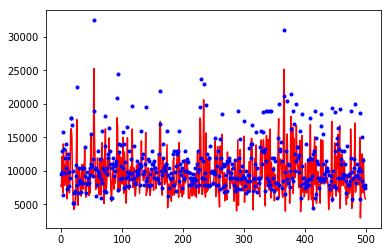

In [48]:
x = np.arange(500)
plt.plot(x, price[0:500], "r-")
plt.plot(x, y_train[0:500], "b.")

plt.show()